# **Tucson Crime Analysis: Income and Street Lighting Impact**

###### Nathan Tebbs, Andrew Hicks, Cole Hageman

## **Research Questions/Hypotheses**
* **Thefts/Violent Crime vs Area**: Do thefts and violent crimes occur more often in richer or poorer neighborhoods?
* **Crime Rate vs Streetlight Presence**: Does the existance/prescence of city streetlights influence crime rates?

---

## **Data Sources**
The data used for this analysis is sourced from the following links:

* [Tucson Police Reported Crimes](https://drive.google.com/file/d/1CpVZ9zpfggyClgxJpz4A6kMvm9bSospO/view?usp=sharing) — [Link to CSV](https://drive.google.com/file/d/161iT39q-IjdAwfS4nYs8reUbW9VMtub1/view?usp=drive_link)
* [Tucson Police Arrests](https://gisdata.tucsonaz.gov/datasets/7c7c881c1fff44ec8a8c2ab612700271_67/explore?location=32.456286%2C-111.225550%2C8.22) — [Link to CSV](https://drive.google.com/file/d/1bJnk0YaQ8xNQAeIJLMWA87VILOG2tEsl/view?usp=drive_link)
* [City of Tucson Streetlight Locations](https://gisdata.tucsonaz.gov/datasets/09ed59b6aae2483aa1bd32837d4aa7e5_19/explore?location=32.193107%2C-110.900400%2C11.16) — [Link to CSV](https://drive.google.com/file/d/1PWVC5zM-AffD-WDhN-9h5rAeCRRMRtac/view?usp=drive_link)
* [Neighborhood Income](https://gisdata.tucsonaz.gov/datasets/59f033d07eae41b0bdc21db87375d721_0/explore?location=32.197986%2C-110.889177%2C10.92) — [Link to CSV](https://drive.google.com/file/d/1_Ys0zVHxuI-XVIq5UpbJJW0Y7Lf0_rPA/view?usp=drive_link)
---

## **Setup and Libraries**

The following libraries are used to analyze and model the data:
* `pandas` and `numpy`: Data manipulation and analysis
* `matplotlib` and `seaborn`: Data visualization
* `statsmodels` and `scikit-learn`: Statistical modeling and machine learning
* `geopy`: Geocoding for location-based analysis

##Importing libraries

In [80]:
# Core libraries
import warnings

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

# Machine learning models and tools
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

# Statistical modeling
import statsmodels.api as sm

# This assumes you have downloaded the training dataset to the My Drive/datasets folder
# If not, go to your Google Drive, make a folder called 'datasets' and put the
# aforementioned csv files into said folder
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading, Merging, and Normalizing datasets**

Before we begin with our analysis, we'll first begin by loading in the appropiate files. Following this section, we'll merge and normalize our provided datasets

In [81]:
# Crime data
crime_df = pd.read_csv('/content/drive/MyDrive/datasets/Tucson_Police_Reported_Crimes.csv')

# Arrest data
arrest_df = pd.read_csv('/content/drive/MyDrive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv')

# Streetlight data
streetlight_df = pd.read_csv('/content/drive/MyDrive/datasets/Streetlights_-_City_of_Tucson_-_Open_Data.csv')

# Neighborhood income data
income_df = pd.read_csv('/content/drive/MyDrive/datasets/Neighborhood_Income.csv')

# **Data Preprocessing & Integration**

### Clean Crime Data
- Convert `DateOccurred` to datetime.
- Extract hour from `TimeOccur`, categorize into time periods (Morning, Afternoon, Evening, Night).
- Filter for years 2018–2021.
- Drop rows missing critical data (`Ward`, `Hour`, `DateOccurred`).
- Standardize `Ward` as an integer.

### Clean Arrest Data
- Convert `datetime_arr` to datetime.
- Drop records missing coordinates or `WARD`.
- Standardize `WARD` and ensure presence of spatial columns (`X`, `Y`).

### Clean Streetlight Data
- Filter for `Status == "Active"`.
- Convert `Wattage` to numeric.
- Drop rows with missing coordinates or wattage.

### Clean Income Data
- Select columns: `WARD`, `MEDHINC_CY`, `AVGHINC_CY`.
- Drop rows with missing income data.
- Standardize `WARD`.
---

## **Dataset Integration**

### Aggregation by Ward
- **Crime_Count**: # of crimes per ward.
- **Arrest_Count**: # of arrests per ward.
- **Night_Crime_Prop**: Proportion of crimes occurring at night per ward.

### Merge into Unified DataFrame
- Merge crime, arrest, and night crime proportion with income data using `WARD`.
- Join with **streetlight data** via **spatial join** using GeoDataFrames.
  - Convert coordinates to same CRS (EPSG:2868).
  - Assign streetlights to `WARD` based on proximity to arrest points.
- Fill missing values with `0` to ensure complete data for analysis.

---

## **How It Supports the Hypotheses**

### Hypothesis 1: **Crime vs Wealth**
- Use `Crime_Count`, `MEDHINC_CY`, and `AVGHINC_CY` to assess correlation between crime and income levels.

### Hypothesis 2: **Streetlights vs Crime**
- Use `Streetlight_Count` and `Night_Crime_Prop` to assess whether lighting reduces total or nighttime crimes.



In [82]:
# Convert DateOccurred to datetime
crime_df['DateOccurred'] = pd.to_datetime(crime_df['DateOccurred'], errors='coerce')
# Clean and extract hour from TimeOccur (make sure input is a str)
def extract_hour(time_str):
    try:
        time_str = str(time_str).strip()
        # Check if the string is numeric and has 3 or 4 digits (e.g., "930", "0930")
        if time_str.isdigit() and 3 <= len(time_str) <= 4:
            # Pad with leading zero if needed (e.g., "930" -> "0930")
            time_str = time_str.zfill(4)
            # Extract hour (first two digits)
            hour = int(time_str[:2])
            # Validate hour (0-23)
            if 0 <= hour <= 23:
                return hour
        return np.nan
    except (ValueError, TypeError):
        return np.nan

crime_df['Hour'] = crime_df['TimeOccur'].apply(extract_hour)

def categorize_time(hour):
  if pd.isna(hour): return 'Unknown'
  elif 5 <= hour < 12: return 'Morning'
  elif 12 <= hour < 17: return 'Afternoon'
  elif 17 <= hour < 22: return 'Evening'
  else: return 'Night'

crime_df['Time_Period'] = crime_df['Hour'].apply(categorize_time)

# Filter for applicable years, then drop rows w/o 'critical' columns
crime_df = crime_df[crime_df['Year'].isin([2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])]
crime_df = crime_df.dropna(subset=['Ward', 'UCRDescription', 'DateOccurred', 'Hour'])

# Standardize Ward as integer
crime_df.loc[:, 'Ward'] = crime_df['Ward'].astype(int)

# --------------------------------------------------------

# Convert datetime_arr to datetime
arrest_df['datetime_arr'] = pd.to_datetime(arrest_df['datetime_arr'], errors='coerce')

# Drop rows with missing coordinates or ward
arrest_df = arrest_df.dropna(subset=['X', 'Y', 'WARD', 'chrgdesc'])

# Standardize WARD as integer
arrest_df.loc[:, 'WARD'] = arrest_df['WARD'].astype(int)

# --------------------------------------------------------

# Drop rows w/o coordinates or wattage
streetlight_df = streetlight_df.dropna(subset=['X', 'Y', 'Wattage'])

# Convert Wattage to numeric
streetlight_df.loc[:, 'Wattage'] = pd.to_numeric(streetlight_df['Wattage'], errors='coerce')

# Filter active streetlights
streetlight_df = streetlight_df[streetlight_df['Status'] == 'Active']

# --------------------------------------------------------

# Clean Income Data
# Select relevant income columns
income_df = income_df[['NAME', 'WARD', 'MEDHINC_CY', 'AVGHINC_CY']].dropna()
income_df.loc[:, 'WARD'] = income_df['WARD'].astype(int)

# --------------------------------------------------------

# Merge Datasets
# Aggregate crime and arrest counts by ward
crime_by_ward = crime_df.groupby('Ward', observed=False).size().reset_index(name='Crime_Count')
arrest_by_ward = arrest_df.groupby('WARD', observed=False).size().reset_index(name='Arrest_Count')

# Calculate proportion of nighttime crimes per ward
night_crimes = crime_df[crime_df['Time_Period'] == 'Night'].groupby('Ward', observed=False).size().reset_index(name='Night_Crime_Count')
total_crimes = crime_df.groupby('Ward', observed=False).size().reset_index(name='Total_Crime_Count')
night_crime_prop = night_crimes.merge(total_crimes, on='Ward')
night_crime_prop['Night_Crime_Prop'] = night_crime_prop['Night_Crime_Count'] / night_crime_prop['Total_Crime_Count']
night_crime_prop = night_crime_prop[['Ward', 'Night_Crime_Prop']]

# Merge with income data
merged_df = income_df.merge(crime_by_ward, left_on='WARD', right_on='Ward', how='left')
merged_df = merged_df.merge(arrest_by_ward, left_on='WARD', right_on='WARD', how='left')
merged_df = merged_df.merge(night_crime_prop, left_on='WARD', right_on='Ward', how='left')
merged_df = merged_df.drop(columns=['Ward'], errors='ignore')

# Calculate streetlight density by ward using spatial join
# Convert arrest and streetlight to GeoDataFrames
# Convert arrest and streetlight to GeoDataFrames
arrest_gdf = gpd.GeoDataFrame(
    arrest_df,
    geometry=[Point(xy) for xy in zip(arrest_df['X'], arrest_df['Y'])],
    crs="EPSG:2868"  # Set correct CRS
)
streetlight_gdf = gpd.GeoDataFrame(
    streetlight_df,
    geometry=[Point(xy) for xy in zip(streetlight_df['X'], streetlight_df['Y'])],
    crs="EPSG:2868"
)

# Use sjoin_nearest for point-to-point assignment
streetlight_by_ward = gpd.sjoin_nearest(
    streetlight_gdf,
    arrest_gdf[['WARD', 'geometry']],
    how='left',
    max_distance=1000  # Adjust distance in feet (EPSG:2868 units)
)
streetlight_count = streetlight_by_ward.groupby('WARD').size().reset_index(name='Streetlight_Count')

# Merge with merged_df and fill NaN values
merged_df = merged_df.merge(streetlight_count, on='WARD', how='left')
merged_df['Streetlight_Count'] = merged_df['Streetlight_Count'].fillna(0)

# Exploratory Data Analysis

This section investigates patterns and relationships between **income**, **streetlight presence**, **crime timing**, and **crime types**.

---

## Correlation Matrix

A heatmap showing the correlation between:

- Median and average income
- Streetlight count
- Crime and arrest counts
- Proportion of nighttime crimes
---
## Scatter Plot: Crime vs Income, with Streetlights & Night Crime

**Visual dimensions:**

X-axis: Median income

Y-axis: Crime count

Color (hue): Night crime proportion

Size: Number of streetlights

**Why it's important:**
Helps visualize income-crime relationships, and shows whether higher streetlight density is associated with lower crime or lower night crime.

---

## Stacked Bar Chart: Crime Types by Ward
**Why it's important:**
Highlights differences in crime composition across wards.
Helps assess whether violent/property crimes dominate in specific income areas

---
## Time-Based Crime Analysis (By Hour (a) & Types by Time Period (b))

**a. Why it's important:**

Identifies when crimes peak during the day, and understanding the timing context of crime



**b. Why it's important:**

Reveals if specific crimes are more common at night, and validates whether streetlighting could mitigate night-related crimes.

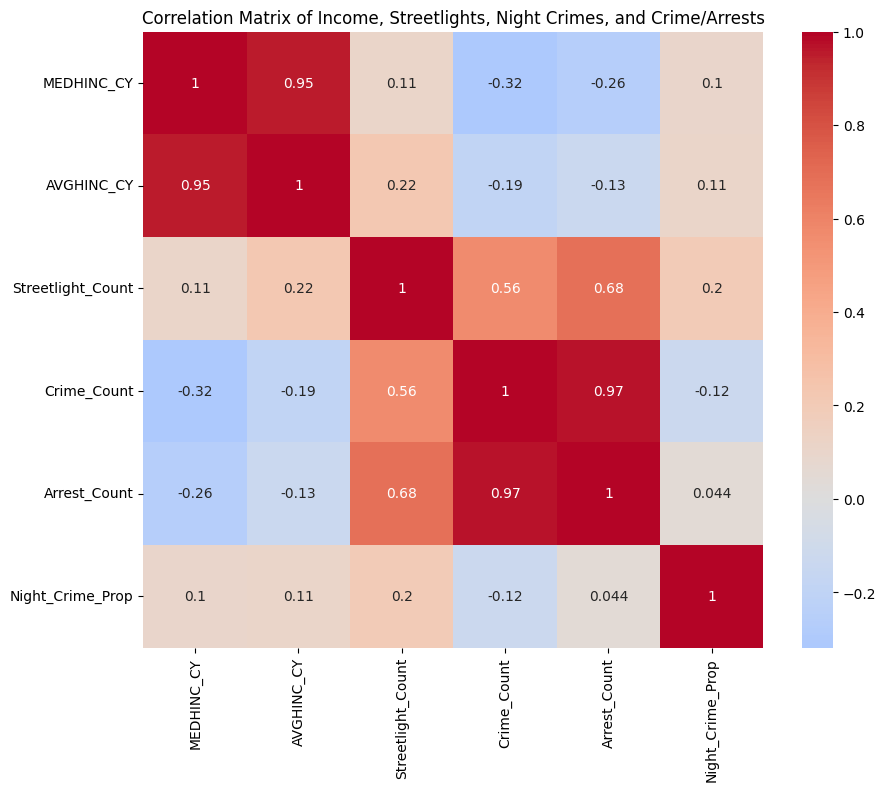

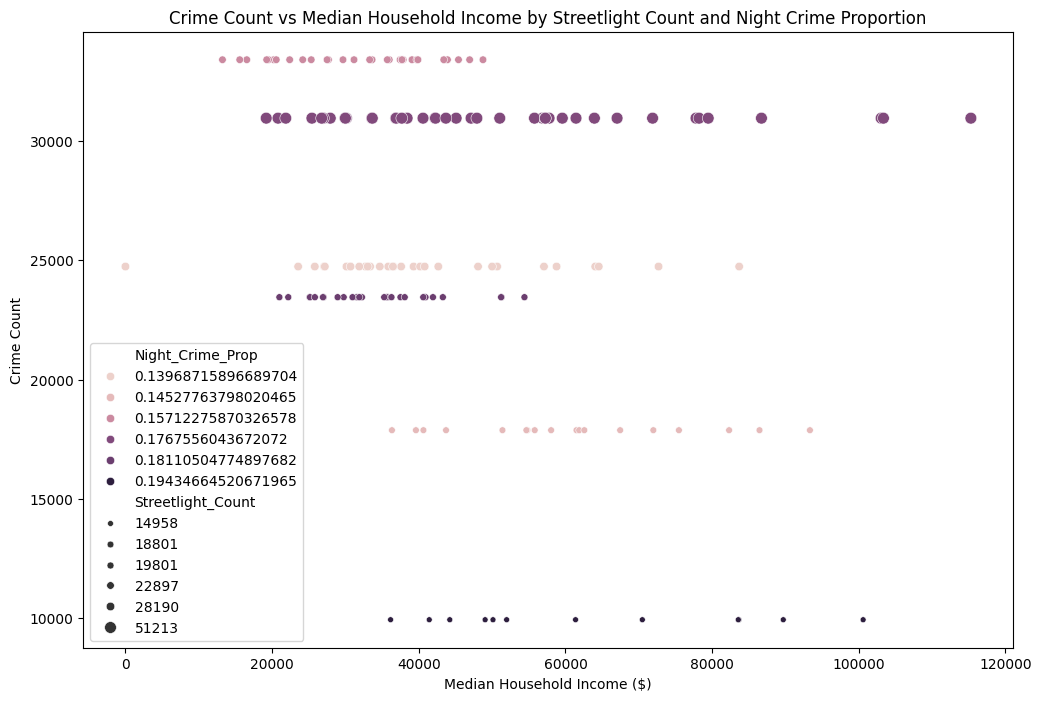

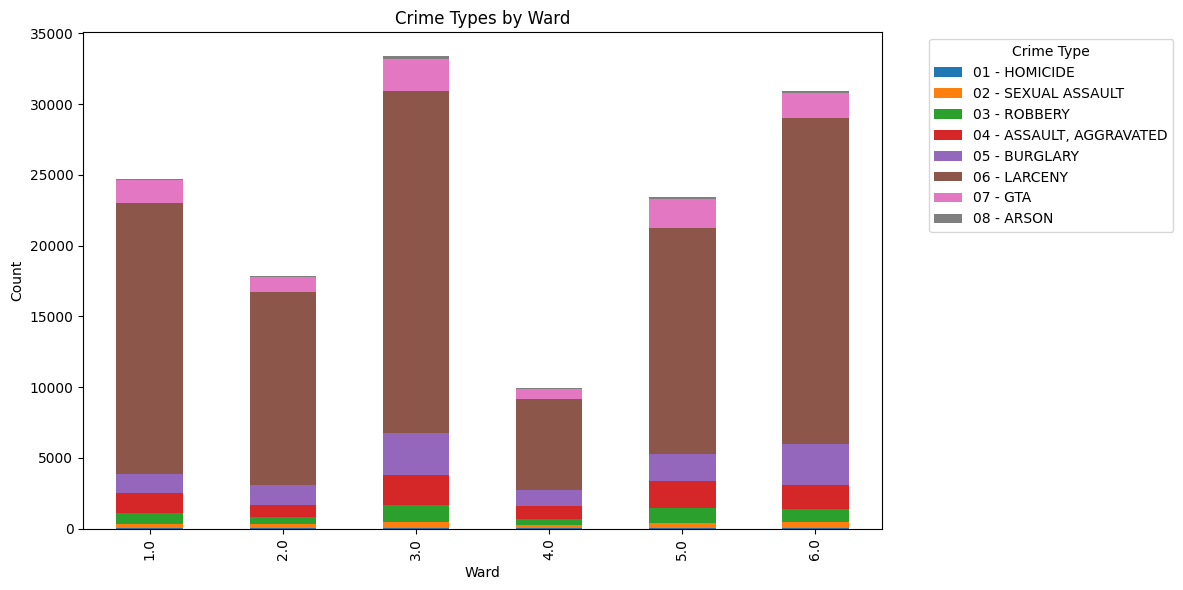

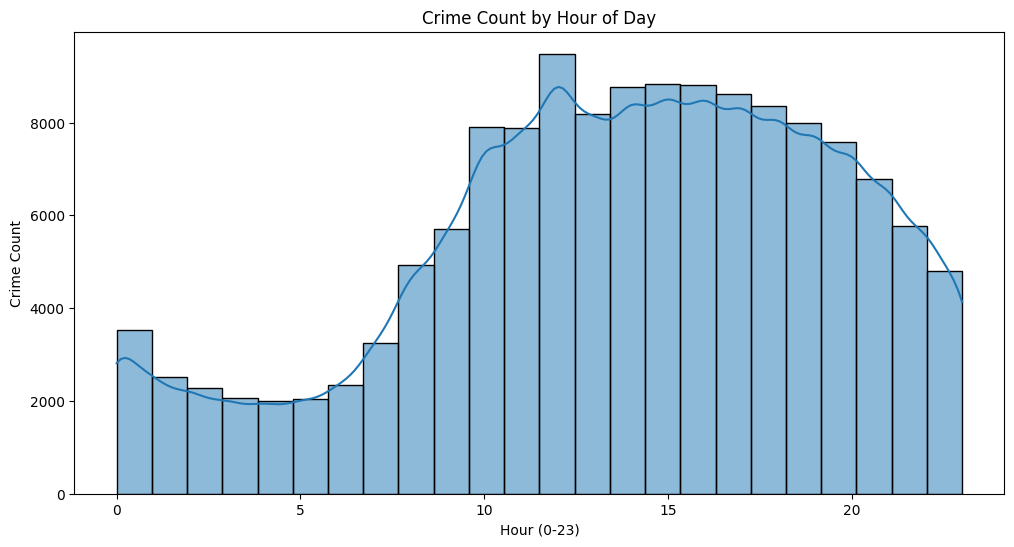

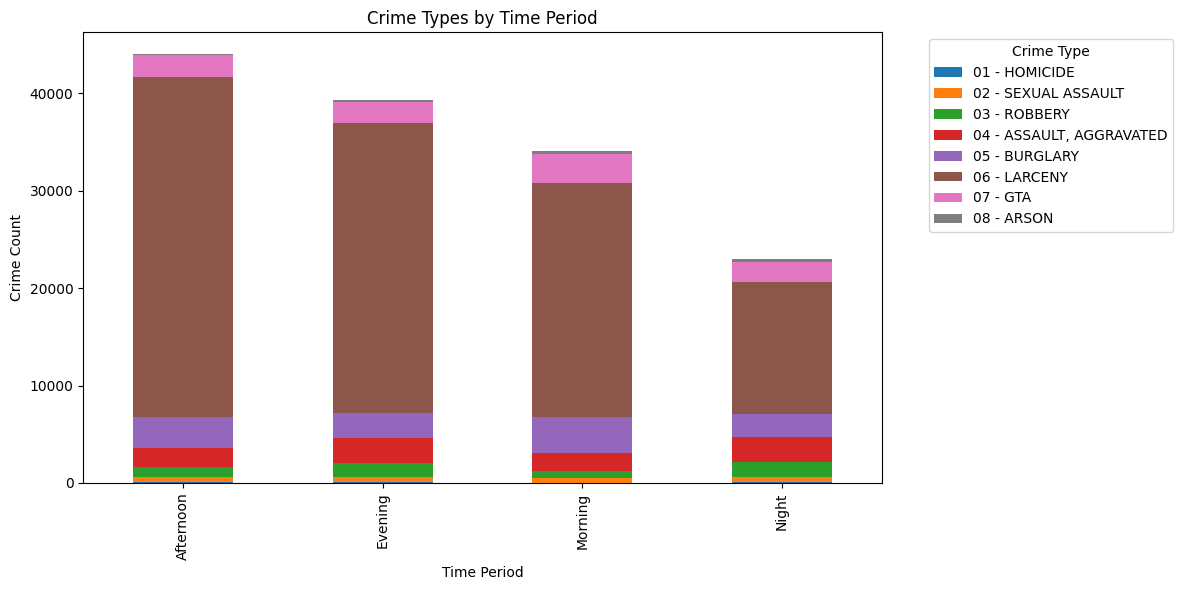

In [83]:
# Correlation Analysis (Heat Map)
correlation_matrix = merged_df[['MEDHINC_CY', 'AVGHINC_CY', 'Streetlight_Count', 'Crime_Count', 'Arrest_Count', 'Night_Crime_Prop']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Income, Streetlights, Night Crimes, and Crime/Arrests')
plt.show()

# Scatter Plots
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='MEDHINC_CY', y='Crime_Count', size='Streetlight_Count', hue='Night_Crime_Prop')
plt.title('Crime Count vs Median Household Income by Streetlight Count and Night Crime Proportion')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Crime Count')
plt.show()

# Crime Types by Ward
crime_types = crime_df.groupby(['Ward', 'UCRDescription'], observed=False).size().unstack(fill_value=0)
crime_types.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Crime Types by Ward')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Crime by Time of Day
# Crime count by hour
plt.figure(figsize=(12, 6))
sns.histplot(data=crime_df, x='Hour', bins=24, kde=True)
plt.title('Crime Count by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Crime Count')
plt.show()

# Crime types by time period
crime_by_time = crime_df.groupby(['Time_Period', 'UCRDescription'], observed=False).size().unstack(fill_value=0)
crime_by_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Crime Types by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Crime Count')
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Ridge Regression Analysis for Hourly Crime Patterns**

This section uses Ridge Regression to model and analyze crime counts by hour for each division in Tucson.

---

## **Steps**:

1. **Group Data by Zone (East, West, South, Midtown)**

2. **Train RR model using `Hour` as predictor and `CrimeCount` as target**:

3. **Store and Visualize Results**:
   - The model, features, target values, and predictions are stored for each division.
   - Scatter plots with regression lines are created to visualize the fit for each division.


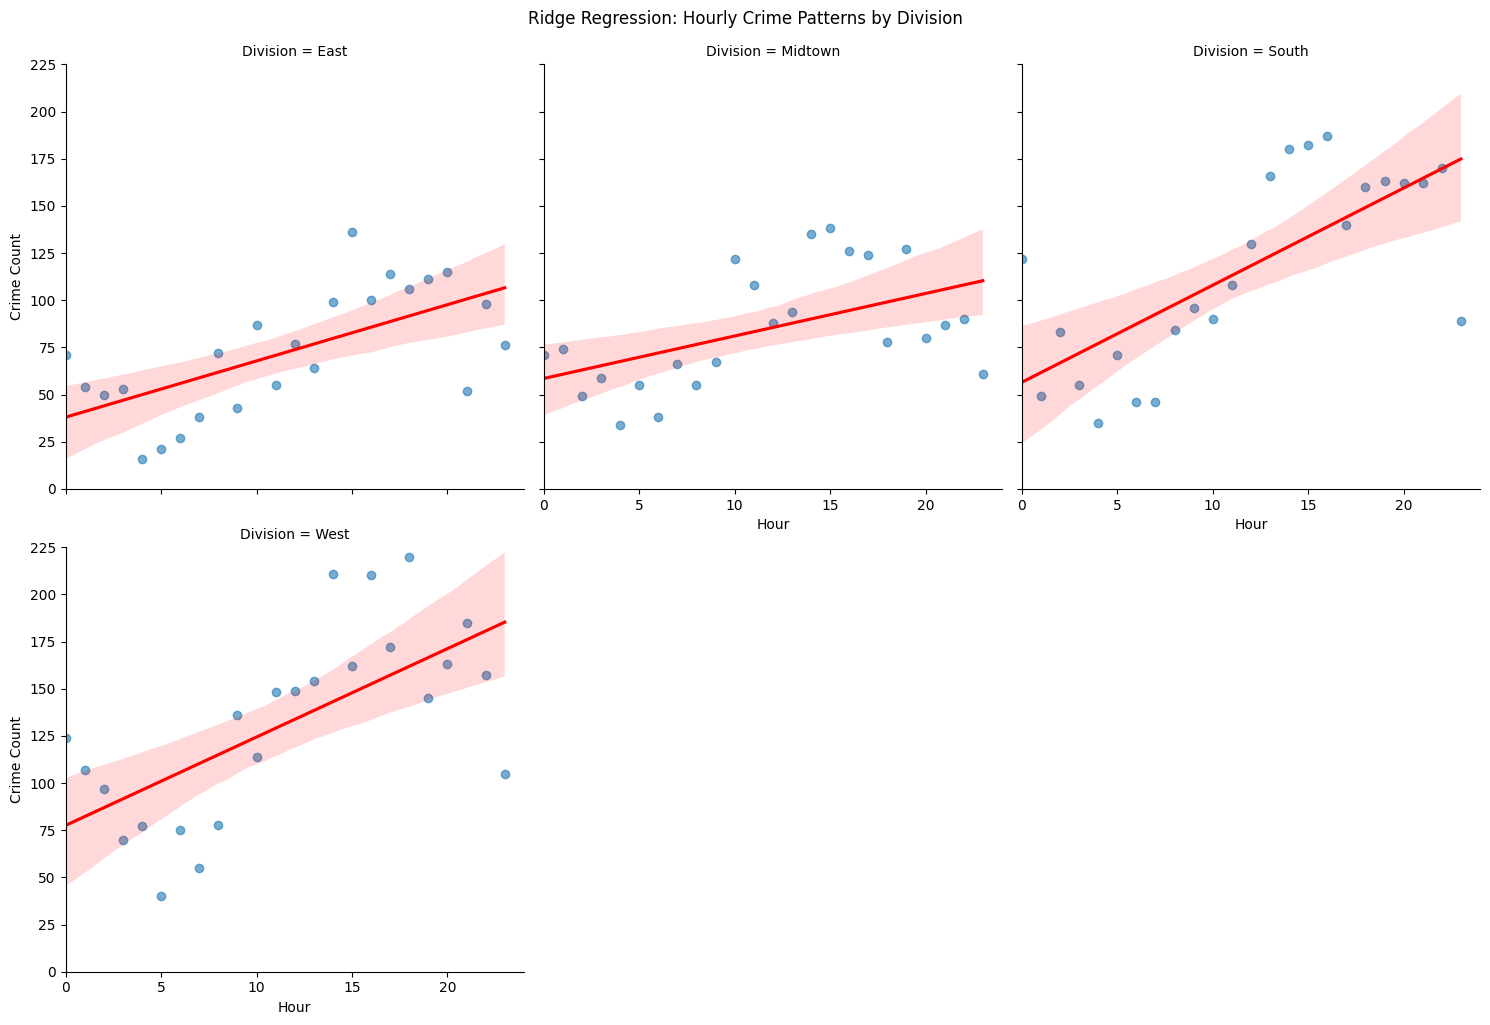

In [84]:
# Re-Load data
reported_crime = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Reported_Crimes.csv",
    parse_dates=["DateOccurred"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

arrests = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv",
    parse_dates=["date_arr", "datetime_arr"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

# Merge Data using their case id
# Aggregate Crime Counts by Hour and Division
merged_data = pd.merge(arrests,reported_crime, left_on='case_id', right_on='IncidentID', how='inner')
merged_data['Hour'] = merged_data['TimeOccur'].apply(extract_hour)
merged_data.dropna(subset=['Hour'], inplace=True)
crime_counts = merged_data.dropna(subset=['Division']).groupby(['Division', 'Hour']).size().reset_index(name='CrimeCount')

# Initialize results storage
division_results = {}

# Multi-Ridge Regression for Each District
for division, group in crime_counts.groupby('Division'):
    if len(group) < 5:  # Skip divisions with too few data points
        continue

    # Features and target
    features = group[['Hour']]
    target = group['CrimeCount']

    # Train Ridge Regression
    ridge_model = Ridge(alpha=1.0)  # Regularization strength
    ridge_model.fit(features, target)

    # Predict
    predictions = ridge_model.predict(features)

    # Store results
    division_results[division] = {
        'Model': ridge_model,
        'Features': features,
        'Target': target,
        'Predictions': predictions
    }


# Plot Regression Line with Actual Points using FacetGrid
g = sns.FacetGrid(
    crime_counts,
    col="Division",
    col_wrap=3,  # Wrap columns after 3 plots
    height=5,  # Height of each individual plot
    aspect=1,  # Aspect ratio of each plot
)

# Iterate through each subplot (Facet)
g.map(sns.regplot, "Hour", "CrimeCount", scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})

# Set axis limits for comparability
g.set(xlim=(0, 24), ylim=(0, crime_counts["CrimeCount"].max() + 5))

# Add overall title and labels
g.fig.suptitle("Ridge Regression: Hourly Crime Patterns by Division", y=1.02)
g.set_axis_labels("Hour", "Crime Count")

# Display the plot
plt.show()

Random Forest Performance:
Accuracy: 0.97
F1-Score: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.80      0.89         5

    accuracy                           0.97        32
   macro avg       0.98      0.90      0.94        32
weighted avg       0.97      0.97      0.97        32


Logistic Regression Performance:
Accuracy: 0.66
F1-Score: 0.42
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.63      0.76        27
           1       0.29      0.80      0.42         5

    accuracy                           0.66        32
   macro avg       0.62      0.71      0.59        32
weighted avg       0.84      0.66      0.70        32



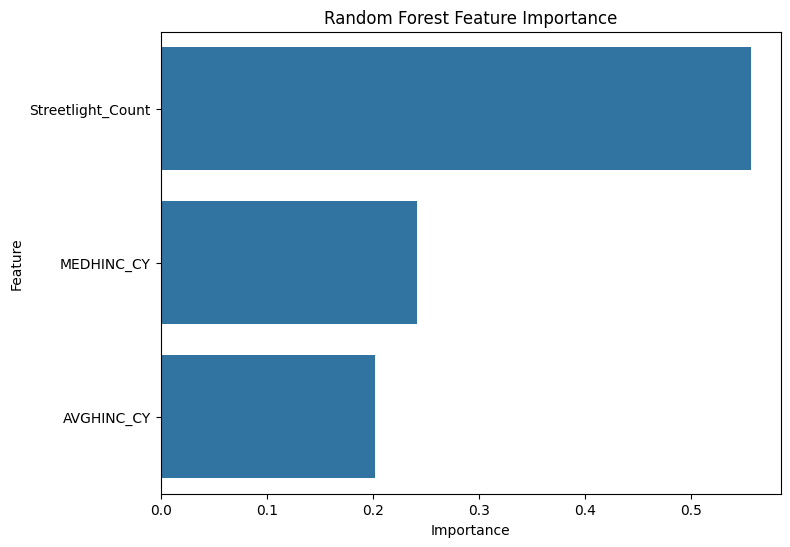

In [87]:
# Predict high crime rate using income, streetlight, and night crime proportion features.

# Prepare Data
# Define high crime rate as top 25th percentile
merged_df['High_Crime'] = (merged_df['Crime_Count'] > merged_df['Crime_Count'].quantile(0.75)).astype(int)
X = merged_df[['MEDHINC_CY', 'AVGHINC_CY', 'Streetlight_Count']]
y = merged_df['High_Crime']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Logistic Regression Model
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Model Evaluation

# Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
print("Random Forest Performance:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"F1-Score: {rf_f1:.2f}")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Logistic Regression Evaluation
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
print("\nLogistic Regression Performance:")
print(f"Accuracy: {lr_accuracy:.2f}")
print(f"F1-Score: {lr_f1:.2f}")
print("Classification Report:")
print(classification_report(y_test, lr_pred))

# K-fold Evaluation on Random Forest model
kf = KFold(n_splits=5, shuffle=True)
rf_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

# K-fold Evaluation on Logistic Regression model
lr_scores = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')

# Results Visualization
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

# **Regression Analysis of Crime Count**
This section implements Ordinary Least Squares (OLS) regression models to analyze how crime count is influenced by factors such as median household income and streetlight count. The objective is to assess the impact of these variables on crime rates and identify key relationships, such as whether  higher median household income is associated with lower crime counts, or the presence of streetlights can reduce crime rates, especially in high-crime areas

---

## Model 1: Crime_Count ~ MEDHINC_CY
### Overview
This model investigates the relationship between **Crime Count** and **Median Household Income `MEDHINC_CY`** using an ordinary least squares linear regression model.


### Summary

An OLS regression was run with `Crime_Count` as the dependent variable and `MEDHINC_CY` as the predictor.

- The negative coefficient indicates a **statistically significant inverse relationship** between income and crime count — as median income increases, crime count tends to decrease.

The scatterplot below visualizes the relationship of a **downward linear trend**, reinforcing the model's finding of a negative association, and therefore shedding light to the fact that, while small, there does exists some relationship with income and crime. More testing, however, is still required as to find whether there exists stronger relationships with crime.

---

## Model 2: Crime Count ~ MEDHINC_CY + StreetLight_Count
### Overview
This model expands on the previous analysis by including both **Median Household Income (MEDHINC_CY)** and **Streetlight Count** as predictors of **Crime Count**, to explore whether **Hypotheses 1 and 2** jointly explain crime variation.


### Summary

An OLS regression was run with `Crime_Count` as the dependent variable, and both `MEDHINC_CY` and `Streetlight_Count` as independent variables.

- Through the help of the feature importance graph, it's apparent that `StreetLight_Count` actually has a higher "weight" when determining crime count, leading to the affirmation of Hypothesis 2.

Model 1: Crime_Count ~ MEDHINC_CY
                            OLS Regression Results                            
Dep. Variable:            Crime_Count   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     17.63
Date:                Thu, 08 May 2025   Prob (F-statistic):           4.48e-05
Time:                        06:31:47   Log-Likelihood:                -1618.7
No. Observations:                 159   AIC:                             3241.
Df Residuals:                     157   BIC:                             3248.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.069e

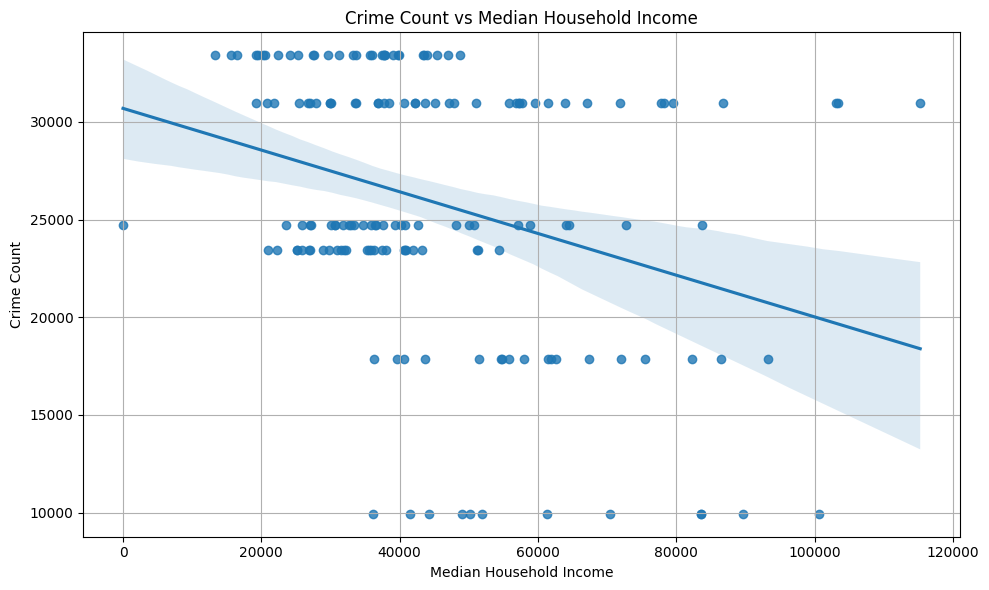



Model 2: Crime_Count ~ MEDHINC_CY + StreetLight_Count
                            OLS Regression Results                            
Dep. Variable:            Crime_Count   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     66.67
Date:                Thu, 08 May 2025   Prob (F-statistic):           1.18e-21
Time:                        06:31:47   Log-Likelihood:                -1578.1
No. Observations:                 159   AIC:                             3162.
Df Residuals:                     156   BIC:                             3171.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

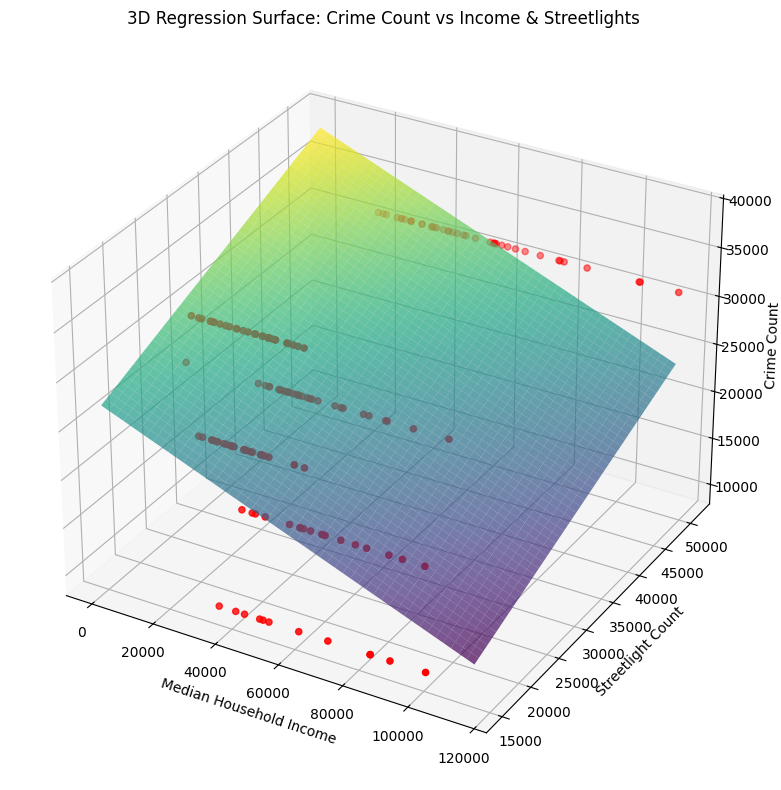

In [86]:
# Model 1: Crime_Count ~ MEDHINC_CY
X_vt = sm.add_constant(merged_df['MEDHINC_CY'])
y_vt = merged_df['Crime_Count']
model = sm.OLS(y_vt, X_vt).fit()

# Summary
print("Model 1: Crime_Count ~ MEDHINC_CY")
print(model.summary())

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x='MEDHINC_CY', y='Crime_Count', data=merged_df)
plt.title('Crime Count vs Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Crime Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------

# Fit the model
X_light = sm.add_constant(merged_df[['Streetlight_Count', 'MEDHINC_CY']])
y_light = merged_df['Crime_Count']
light_model = sm.OLS(y_light, X_light).fit()

# Summary
print("\n\nModel 2: Crime_Count ~ MEDHINC_CY + StreetLight_Count")
print(light_model.summary())

# Create grid for plotting
medhinc_range = np.linspace(merged_df['MEDHINC_CY'].min(), merged_df['MEDHINC_CY'].max(), 50)
streetlight_range = np.linspace(merged_df['Streetlight_Count'].min(), merged_df['Streetlight_Count'].max(), 50)
medhinc_grid, streetlight_grid = np.meshgrid(medhinc_range, streetlight_range)

# Predict crime counts
grid_df = pd.DataFrame({
    'const': 1,
    'Streetlight_Count': streetlight_grid.ravel(),
    'MEDHINC_CY': medhinc_grid.ravel()
})
crime_pred = light_model.predict(grid_df).values.reshape(medhinc_grid.shape)

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(medhinc_grid, streetlight_grid, crime_pred, cmap='viridis', alpha=0.7)
ax.scatter(merged_df['MEDHINC_CY'], merged_df['Streetlight_Count'], merged_df['Crime_Count'], color='red', s=20)
ax.set_xlabel('Median Household Income')
ax.set_ylabel('Streetlight Count')
ax.set_zlabel('Crime Count')
ax.set_title('3D Regression Surface: Crime Count vs Income & Streetlights')
plt.tight_layout()
plt.show()